In [6]:
import pandas as pd
import xarray as xr
import numpy as np
import glob
import os
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt
import multiprocessing as mp
from trend_calculator import calculate_trend

In [4]:
# Specify the region of interest
min_row = 21
min_col = 5
max_row = 25
max_col = 8

file_names = [f"r_{row:02}_c_{col:02}" for row in range(min_row, max_row+1) for col in range(min_col, max_col+1)]

print(len(file_names))

20


In [7]:
# # read in ../data_file/august_data.nc
# ds = xr.open_dataset("../data_files/august_data.nc")

# open ds.to_netcdf('../data_files/pre_2003.nc')
ds = xr.open_dataset('../data_files/august_data_post_2003.nc')

In [8]:
# Group the data by year 
# Calculate the mean and standard deviation for each year
annual_grouped = ds.groupby('time.year')
annual_mean = annual_grouped.mean(dim='time')
# annual_std = annual_grouped.std(dim='time')

annual_grouped

DatasetGroupBy, grouped over 'year'
20 groups with labels 2003, 2004, 2005, ..., 2021, 2022.

## Loop through each pixel to calculate the trendline and RMSE 
#### Warning: python looping is very slow

In [9]:
print(ds)

<xarray.Dataset>
Dimensions:  (time: 620, x: 200, y: 250)
Coordinates:
  * x        (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y        (y) int64 -2333975 -2332975 -2331975 ... -2086975 -2085975 -2084975
  * time     (time) datetime64[ns] 2003-08-01 2003-08-02 ... 2022-08-31
Data variables:
    chla     (time, x, y) float64 ...


In [10]:
annual_mean

<xarray.Dataset>
Dimensions:  (year: 20, x: 200, y: 250)
Coordinates:
  * x        (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y        (y) int64 -2333975 -2332975 -2331975 ... -2086975 -2085975 -2084975
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2018 2019 2020 2021 2022
Data variables:
    chla     (year, x, y) float64 0.4494 0.4693 0.4834 0.4971 ... nan nan nan

In [11]:
annual_mean['year']

<xarray.DataArray 'year' (year: 20)>
array([2003, 2004, 2005, 2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014,
       2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022])
Coordinates:
  * year     (year) int64 2003 2004 2005 2006 2007 ... 2018 2019 2020 2021 2022

In [12]:
output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003'
if not os.path.exists(output_path):
    os.makedirs(output_path)

# pencil decomposition
x_values = np.array_split(ds['x'].values, 25)
y_values = ds['y'].values 

time_values_init = annual_mean['year']

# for i in range(2):
for i in range(len(x_values)):
    # ds_trend = xr.Dataset(coords={dim: ds.coords[dim] for dim in ['x', 'y']})

    ds_trend = xr.Dataset(coords={'x': x_values[i], 'y': y_values})

    ds_trend['trendline_slope']     = xr.DataArray(np.zeros((len(x_values[i]), len(y_values))), coords=[('x', x_values[i]), ('y', y_values)])
    ds_trend['trendline_intercept'] = xr.DataArray(np.zeros((len(x_values[i]), len(y_values))), coords=[('x', x_values[i]), ('y', y_values)])
    ds_trend['rsme']                = xr.DataArray(np.zeros((len(x_values[i]), len(y_values))), coords=[('x', x_values[i]), ('y', y_values)])
    
    print(f"\nStarting batch {i+1} of {len(x_values)}")

    with mp.Pool(mp.cpu_count()) as pool:
        results = list(tqdm(pool.imap(calculate_trend, [(x, y, annual_mean, time_values_init) for x in x_values[i] for y in y_values]), total=len(x_values[i])*len(y_values)))


    # pool.imap(calculate_trend, [(x, y, annual_mean, time_values_init) for x in x_values[i] for y in y_values])


    print("\nStoring Results")
    for x, y, slope, intercept, rmse in tqdm(results):
        ds_trend['trendline_slope'].loc[dict(x=x, y=y)] = slope
        ds_trend['trendline_intercept'].loc[dict(x=x, y=y)] = intercept
        ds_trend['rsme'].loc[dict(x=x, y=y)] = rmse

    # print("Saving Dataset")
    output_name = f"ds_trend__aug_post2003_batch_{i+1}.nc"

    # ds_trend.to_netcdf(f"ds_trend_batch_{i+1}.nc")
    ds_trend.to_netcdf(os.path.join(output_path, output_name))

# 50 batches.. 2 files finished in 27 mins. That is ~11 min per batch + 2.5 min to save


Starting batch 1 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 2 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 3 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 4 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))



Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 5 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 6 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 7 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 8 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 9 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 10 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))



Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 11 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 12 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 13 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 14 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 15 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 16 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 17 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 18 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 19 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))



Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 20 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 21 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 22 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 23 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 24 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]


Starting batch 25 of 25


  0%|          | 0/2000 [00:00<?, ?it/s]

/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*args, **kwds))
/Users/tara/opt/anaconda3/envs/changes/lib/python3.11/multiprocessing/pool.py:125: RankWarning: Polyfit may be poorly conditioned
  result = (True, func(*a


Storing Results


  0%|          | 0/2000 [00:00<?, ?it/s]

## Read the batches in 

In [30]:
output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003'
# glob all the files in outputpath with *.nc and load in the mfdataset
files = glob.glob(os.path.join(output_path, '*.nc'))    

# ds_trend = xr.open_mfdataset(files, combine='by_coords')

# ds_combined = xr.open_mfdataset(os.path.join(output_path, output_name), combine='by_coords')

In [31]:
files

['/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/ds_trend__aug_post2003_batch_1.nc',
 '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/ds_trend__aug_post2003_batch_10.nc',
 '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/ds_trend__aug_post2003_batch_11.nc',
 '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/ds_trend__aug_post2003_batch_12.nc',
 '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/ds_trend__aug_post2003_batch_13.nc',
 '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/ds_trend__aug_post2003_batch_14.nc',
 '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/ds_trend__aug_post2003_batch_15.nc',
 '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/ds_trend__aug_post2003_batch_16.nc',
 '/Volumes/Seagate/CHANGES/data_r

In [32]:
ds_trend = xr.open_mfdataset(files[:], combine='by_coords')

In [33]:
# write to output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn/august2003/jakobshavn_august2003_trend.nc'
ds_trend.to_netcdf(os.path.join(output_path, 'jakobshavn_august2003_trend.nc'))

KeyboardInterrupt: 

### Inspect a single pixel. 
Plot the trendline and 

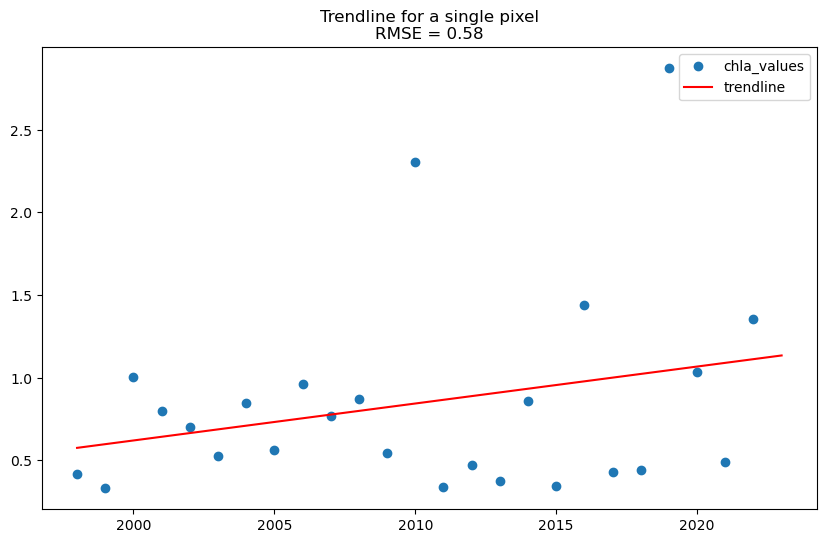

In [24]:
import matplotlib.pyplot as plt

x_cell = 4
y_cell = 100

# Extract the slope and intercept for the first pixel
slope       = ds_trend['trendline_slope'].isel(x=x_cell, y=y_cell).values
intercept   = ds_trend['trendline_intercept'].isel(x=x_cell, y=y_cell).values
rmse        = ds_trend['rsme'].isel(x=x_cell, y=y_cell).values

# Extract the chla_values for the first pixel
chla_values = annual_mean['chla'].isel(x=x_cell, y=y_cell).values

# Calculate the trendline
trendline   = slope * time_values_init + intercept

# Plot the chla_values and the trendline
plt.figure(figsize=(10, 6))
plt.plot(time_values_init, chla_values, 'o', label='chla_values')
plt.plot(time_values_init, trendline, 'r', label='trendline')

plt.title('Trendline for a single pixel\nRMSE = {:.2f}'.format(rmse))
plt.legend()
plt.show()

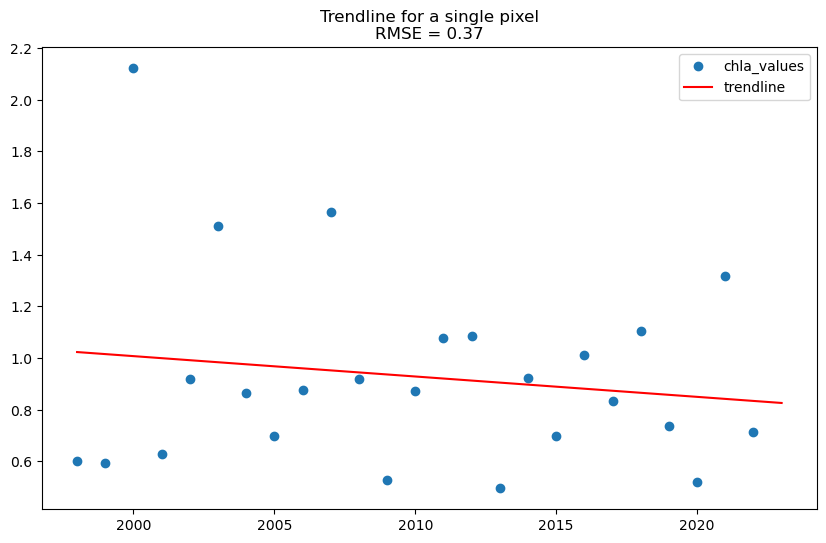

In [44]:
import matplotlib.pyplot as plt

x_cell = 199
y_cell = 200

# Extract the slope and intercept for the first pixel
slope       = ds_trend['trendline_slope'].isel(x=x_cell, y=y_cell).values
intercept   = ds_trend['trendline_intercept'].isel(x=x_cell, y=y_cell).values
rmse        = ds_trend['rsme'].isel(x=x_cell, y=y_cell).values

# Extract the chla_values for the first pixel
chla_values = annual_mean['chla'].isel(x=x_cell, y=y_cell).values

# Calculate the trendline
trendline   = slope * time_values_init + intercept

# Plot the chla_values and the trendline
plt.figure(figsize=(10, 6))
plt.plot(time_values_init, chla_values, 'o', label='chla_values')
plt.plot(time_values_init, trendline, 'r', label='trendline')

plt.title('Trendline for a single pixel\nRMSE = {:.2f}'.format(rmse))
plt.legend()
plt.show()


In [45]:
# store ds_trend in ds_trend.nc
# ds_trend.to_netcdf('/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/ds_trend.nc')

In [19]:
slope_data = ds_trend['trendline_slope'].values


In [27]:
# Get the chla data as a 2D numpy array, flip it along the x-axis, and rotate 90 degrees clockwise
slope_data = ds_trend['rsme'].values

slope_data = np.fliplr(slope_data)
# # chla_data = np.fliplr(ds_mean.chla.values)
rotated_data = np.rot90(slope_data, 1)


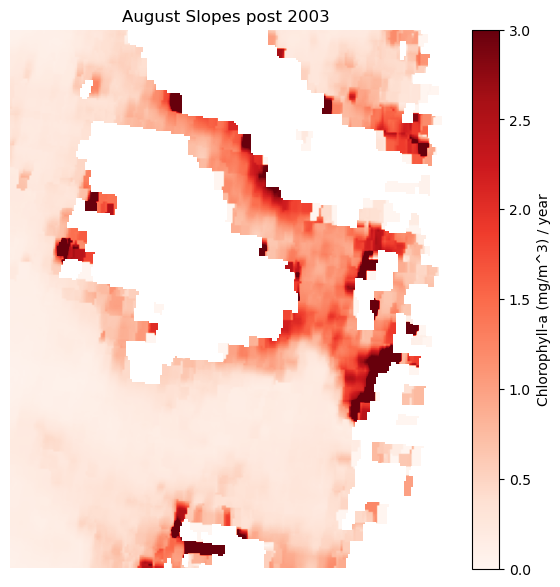

In [29]:
# # Get the years from the datetime column (for title)
# years = ds.datetime.dt.year.values
# years = np.unique(years)
# years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_data, origin='lower', cmap='Reds', vmin = 0, vmax=3) #, vmin=0, vmax=3, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('August Slopes post 2003')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3) / year')

# Show & close the plot
plt.show()
plt.close('all')

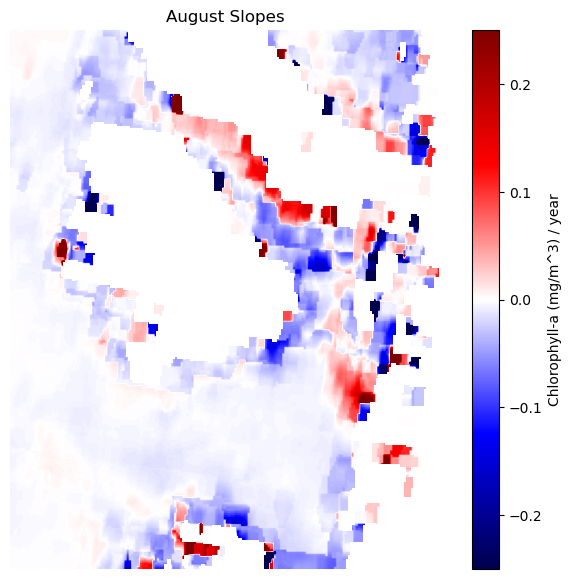

In [27]:
# # Get the years from the datetime column (for title)
# years = ds.datetime.dt.year.values
# years = np.unique(years)
# years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_data, origin='lower', cmap='seismic', vmin = -.25, vmax=.25) #, vmin=0, vmax=3, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('August Slopes')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3) / year')

# Show & close the plot
plt.show()
plt.close('all')

# TO DO

run transpose on batches then flip, rotate, plot

In [60]:
# output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn'
output_path = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn'
files = glob.glob(os.path.join(output_path, '*.nc'))    
# sort files
files.sort()
files

['/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_1.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_10.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_11.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_12.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_13.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_14.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_15.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_16.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_17.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_18.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/d

In [61]:
# load in /Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/ds_trend.nc
ds_trend = xr.open_mfdataset(files[:], combine='by_coords')

In [62]:
print(ds_trend)


<xarray.Dataset>
Dimensions:              (x: 200, y: 250)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -204475 -203475
  * y                    (y) int64 -2333975 -2332975 ... -2085975 -2084975
Data variables:
    trendline_slope      (x, y) float64 dask.array<chunksize=(8, 250), meta=np.ndarray>
    trendline_intercept  (x, y) float64 dask.array<chunksize=(8, 250), meta=np.ndarray>
    rsme                 (x, y) float64 dask.array<chunksize=(8, 250), meta=np.ndarray>


In [ ]:
# output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/Transposed'
# transposed_directory = output_path

# # Create the output path if it does not exist
# os.makedirs(output_path, exist_ok=True)

# print(len(existing_files), "files to process")

# for file in existing_files:
#     print("Processing file {:d} of {:d}".format(existing_files.index(file)+1, len(existing_files)), end='\r')

#     base_name = os.path.basename(file)
#     output_file = os.path.join(output_path, base_name)

#     # If the output file already exists, skip it
#     if os.path.exists(output_file):
#         print("Output file {:s} already exists, skipping".format(base_name))
#         continue

#     ds = xr.open_dataset(file)

#     # Get the chla data and swap the x and y dimensions
#     chla_data = ds.chla.values
#     swapped_data = chla_data.swapaxes(1, 2)

#     # Create a new DataArray with the swapped data and the original coordinates
#     swapped_da = xr.DataArray(swapped_data, coords=ds.chla.coords, dims=ds.chla.dims)
#     swapped_ds = swapped_da.to_dataset(name='chla')

#     # Save the swapped dataset to a new file
#     swapped_ds.to_netcdf(output_file)

#     ds.close()
#     swapped_ds.close()

In [12]:
files

['/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_1.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_10.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_11.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_12.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_13.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_14.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_15.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_16.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_17.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_18.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/d

In [14]:
ds = xr.open_dataset(files[0])
ds

<xarray.Dataset>
Dimensions:              (x: 8, y: 250)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -396475 -395475
  * y                    (y) int64 -2333975 -2332975 ... -2085975 -2084975
Data variables:
    trendline_slope      (x, y) float64 ...
    trendline_intercept  (x, y) float64 ...
    rsme                 (x, y) float64 ...

In [11]:
output_path = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/transposed'
transposed_directory = output_path

for file in files:
    print("Processing file {:d} of {:d}".format(files.index(file)+1, len(files)), end='\r')

    base_name = os.path.basename(file)
    output_file = os.path.join(output_path, base_name)

    # If the output file already exists, skip it
    if os.path.exists(output_file):
        print("Output file {:s} already exists, skipping".format(base_name))
        continue

    ds = xr.open_dataset(file)

    # Get the slope, intercept, and rmse and swap the axis
    slope_data = ds.trendline_slope.values
    intercept_data = ds.trendline_intercept.values
    rmse_data = ds.rsme.values

    swapped_slope = slope_data.swapaxes(1, 2)
    swapped_intercept = intercept_data.swapaxes(1, 2)
    swapped_rmse = rmse_data.swapaxes(1, 2)

    # Create a new DataArray with the swapped data and the original coordinates
    swapped_slope_da = xr.DataArray(swapped_slope, coords=ds.trendline_slope.coords, dims=ds.trendline_slope.dims)
    swapped_slope_ds = swapped_slope_da.to_dataset(name='trendline_slope')

    swapped_intercept_da = xr.DataArray(swapped_intercept, coords=ds.trendline_intercept.coords, dims=ds.trendline_intercept.dims)
    swapped_intercept_ds = swapped_intercept_da.to_dataset(name='trendline_intercept')

    swapped_rmse_da = xr.DataArray(swapped_rmse, coords=ds.rsme.coords, dims=ds.rsme.dims)
    swapped_rmse_ds = swapped_rmse_da.to_dataset(name='rsme')

    # Save the swapped dataset to a new file
    swapped_slope_ds.to_netcdf(output_file+"_slope")
    swapped_intercept_ds.to_netcdf(output_file+"_intercept")
    swapped_rmse_ds.to_netcdf(output_file+"_rmse")


AxisError: axis2: axis 2 is out of bounds for array of dimension 2

In [17]:
output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/Transposed'
files = glob.glob(os.path.join(output_path, '*.nc'))    
# sort files
files.sort()
files

# load in /Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/ds_trend.nc
ds_trend = xr.open_mfdataset(files[:25], combine='by_coords')

ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [16]:
output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/Transposed'
files = glob.glob(os.path.join(output_path, '*.nc'))    
# sort files
files.sort()
files

# load in /Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/ds_trend.nc
ds_trend = xr.open_mfdataset(files[:25], combine='by_coords')

# Get the chla data as a 2D numpy array, flip it along the x-axis, and rotate 90 degrees clockwise
slope_data = ds_trend['trendline_slope'].values

slope_data = np.fliplr(slope_data)
# # chla_data = np.fliplr(ds_mean.chla.values)
rotated_data = np.rot90(slope_data, 1)


ValueError: Could not find any dimension coordinates to use to order the datasets for concatenation

In [ ]:
# for file in files:
#     print("Processing file {:d} of {:d}".format(files.index(file)+1, len(files)), end='\r')

#     base_name = os.path.basename(file)
#     output_file = os.path.join(output_path, base_name)

#     # If the output file already exists, skip it
#     if os.path.exists(output_file):
#         print("Output file {:s} already exists, skipping".format(base_name))
#         continue

#     ds = xr.open_dataset(file)

#     # Transpose the variables in ds_trend
#     ds_trend['trendline_slope'] = ds_trend['trendline_slope'].transpose()
#     ds_trend['trendline_intercept'] = ds_trend['trendline_intercept'].transpose()
#     ds_trend['rsme'] = ds_trend['rsme'].transpose()

#     # Save the transposed dataset to a new file
#     ds_trend.to_netcdf(output_file)

#     ds.close()
#     ds_trend.close()

In [15]:
# read in /Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/ds_trend.nc
ds_trend = xr.open_mfdataset(files[:], combine='by_coords')

# plot the trendline_slope as heatmap
# Get the chla data as a 2D numpy array, flip it along the x-axis, and rotate 90 degrees clockwise
slope_data = ds_trend['trendline_slope'].values

slope_data = np.fliplr(slope_data)
# # chla_data = np.fliplr(ds_mean.chla.values)
rotated_data = np.rot90(slope_data, 1)


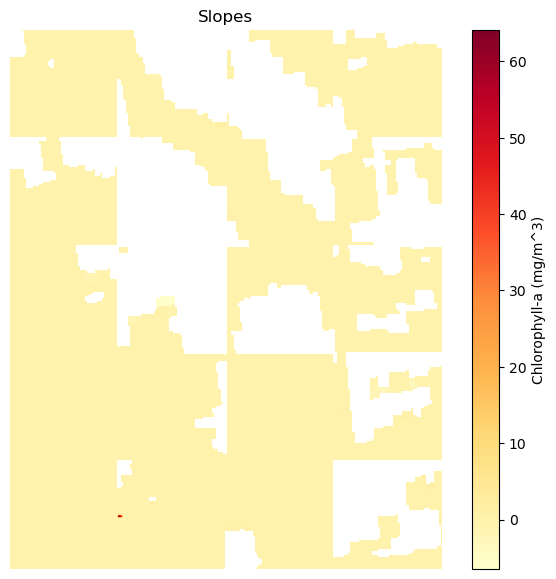

In [18]:
# # Get the years from the datetime column (for title)
# years = ds.datetime.dt.year.values
# years = np.unique(years)
# years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_data, origin='lower', cmap='YlOrRd') #, vmin=0, vmax=3, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('Slopes')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

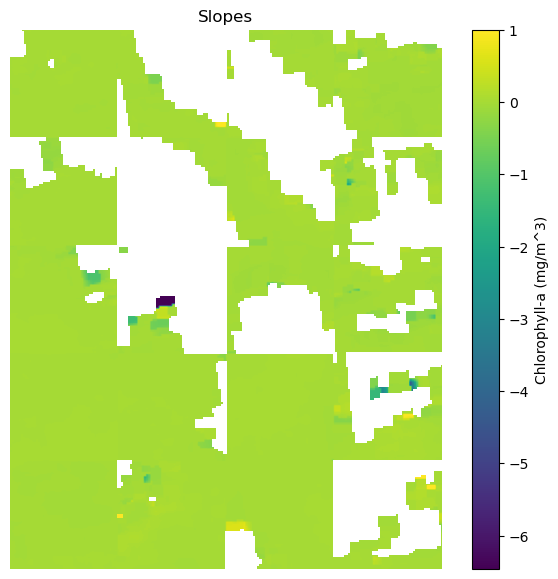

In [50]:
# # Get the years from the datetime column (for title)
# years = ds.datetime.dt.year.values
# years = np.unique(years)
# years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# rotate ds_trend['trendline_slope'] 90 degrees clockwise
rotated_data = np.rot90(ds_trend['trendline_slope'].values, 1)

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_data, vmax = 1) #, origin='lower') #, cmap='YlOrRd') #, vmin=0, vmax=3, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('Slopes')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

In [21]:
import numpy as np

# Split the 'x' and 'y' coordinates into 50x50 cells
x_splits = np.array_split(ds_trend.x, 20)
y_splits = np.array_split(ds_trend.y, 20)

# Initialize a list to store the new datasets
new_datasets = []

# For each 50x50 cell
for i in range(20):
    for j in range(20):
        # Select the data for this cell
        ds_cell = ds_trend.sel(x=x_splits[i], y=y_splits[j])

        # Transpose the variables
        ds_cell['trendline_slope'] = ds_cell['trendline_slope'].transpose()
        ds_cell['trendline_intercept'] = ds_cell['trendline_intercept'].transpose()
        ds_cell['rsme'] = ds_cell['rsme'].transpose()

        # Store the transposed data in the list
        new_datasets.append(ds_cell)

# Combine the new datasets into a single xarray
new_ds = xr.concat(new_datasets, dim=['x', 'y'])

ValueError: conflicting sizes for dimension 'concat_dim': length 2 on 'concat_dim' and length 400 on {'x': 'x', 'y': 'y', 'concat_dim': 'trendline_slope'}

In [22]:
# import numpy as np

# # Split the 'x' and 'y' coordinates into 50x50 cells
# x_splits = np.array_split(ds_trend.x, 20)
# y_splits = np.array_split(ds_trend.y, 20)

# # Initialize a 2D list to store the new datasets
# new_datasets = [[] for _ in range(20)]

# # For each 50x50 cell
# for i in range(20):
#     for j in range(20):
#         # Select the data for this cell
#         ds_cell = ds_trend.sel(x=x_splits[i], y=y_splits[j])

#         # Transpose the variables
#         ds_cell['trendline_slope'] = ds_cell['trendline_slope'].transpose()
#         ds_cell['trendline_intercept'] = ds_cell['trendline_intercept'].transpose()
#         ds_cell['rsme'] = ds_cell['rsme'].transpose()

#         # Store the transposed data in the list
#         new_datasets[i].append(ds_cell)

# # Concatenate the datasets along the 'y' dimension
# concat_along_y = [xr.concat(datasets, dim='y') for datasets in new_datasets]

# # Concatenate the resulting datasets along the 'x' dimension
# new_ds = xr.concat(concat_along_y, dim='x')

In [35]:
import numpy as np

# Split the 'x' and 'y' coordinates into 50x50 cells
x_splits = np.array_split(ds_trend.x, 20)
y_splits = np.array_split(ds_trend.y, 20)

# Initialize a 2D list to store the new datasets
new_datasets = [[] for _ in range(20)]

# For each 50x50 cell
for i in range(20):
    for j in range(20):
        # Select the data for this cell
        ds_cell = ds_trend.sel(x=x_splits[i], y=y_splits[j])

        # Transpose the variables and swap the axes
        ds_cell = ds_cell.transpose('y', 'x')

        # Store the transposed data in the list
        new_datasets[i].append(ds_cell)

# Concatenate the datasets along the 'y' dimension
concat_along_y = [xr.concat(datasets, dim='y') for datasets in new_datasets]

# Concatenate the resulting datasets along the 'x' dimension
new_ds = xr.concat(concat_along_y, dim='x')

In [41]:
x_splits[0]

<xarray.DataArray 'x' (x: 10)>
array([-402475, -401475, -400475, -399475, -398475, -397475, -396475,
       -395475, -394475, -393475])
Coordinates:
  * x        (x) int64 -402475 -401475 -400475 ... -395475 -394475 -393475

In [73]:
new_ds

<xarray.Dataset>
Dimensions:              (x: 200, y: 250)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -204475 -203475
  * y                    (y) int64 -2333975 -2332975 ... -2085975 -2084975
Data variables:
    trendline_slope      (y, x) float64 dask.array<chunksize=(13, 8), meta=np.ndarray>
    trendline_intercept  (y, x) float64 dask.array<chunksize=(13, 8), meta=np.ndarray>
    rsme                 (y, x) float64 dask.array<chunksize=(13, 8), meta=np.ndarray>

In [69]:

# plot the trendline_slope as heatmap
# Get the chla data as a 2D numpy array, flip it along the x-axis, and rotate 90 degrees clockwise
slope_data = new_ds['trendline_slope'].values

slope_data = np.fliplr(slope_data)
# # chla_data = np.fliplr(ds_mean.chla.values)
rotated_data = np.rot90(slope_data, 1)
# 

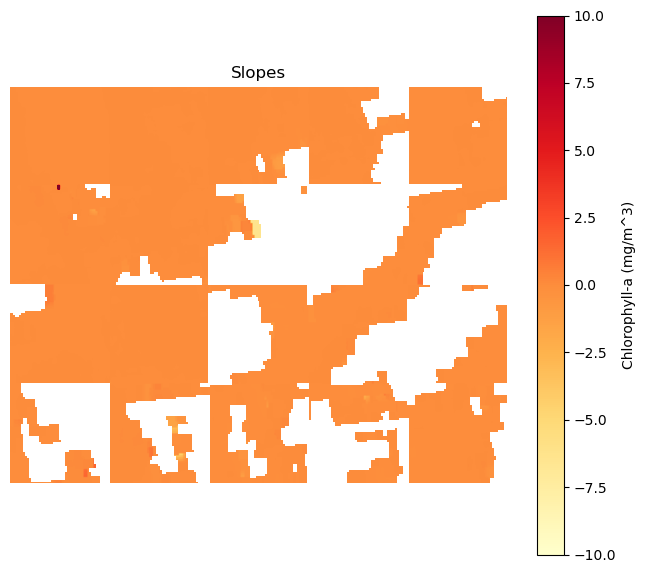

In [78]:
# rotated_data = new_ds['trendline_slope'].values

ds_trend = xr.open_mfdataset(files[:], combine='by_coords')


# # Get the years from the datetime column (for title)
# years = ds.datetime.dt.year.values
# years = np.unique(years)
# years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(ds_trend['trendline_slope'].values, origin='upper', cmap='YlOrRd', vmin=-10, vmax = 10) #, vmin=0, vmax=3, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('Slopes')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

### try to slice


In [80]:
# Select the variables and values for the x values and y values indexed at 0 to 50
selected_ds = ds_trend.isel(x=slice(0, 50), y=slice(0,50))

# Print the selected data
print(selected_ds)

<xarray.Dataset>
Dimensions:              (x: 50, y: 50)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -354475 -353475
  * y                    (y) int64 -2333975 -2332975 ... -2285975 -2284975
Data variables:
    trendline_slope      (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>
    trendline_intercept  (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>
    rsme                 (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>


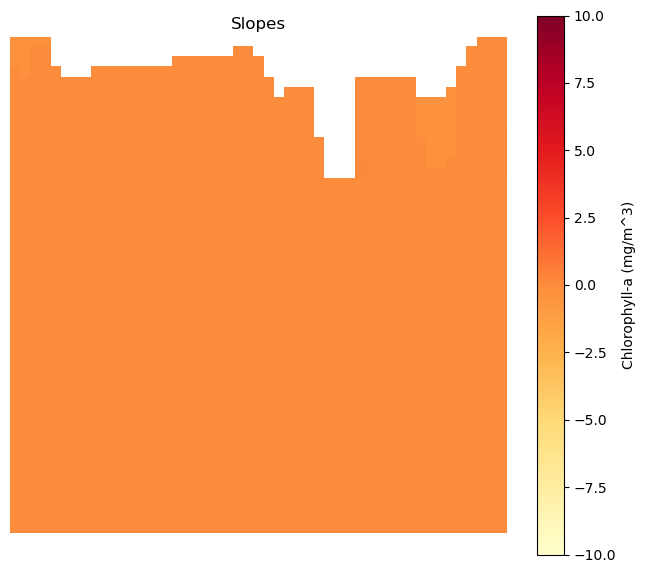

In [77]:

# plot the trendline_slope as heatmap
# Get the chla data as a 2D numpy array, flip it along the x-axis, and rotate 90 degrees clockwise
slope_data = selected_ds['trendline_slope'].values

slope_data = np.fliplr(slope_data)
# # chla_data = np.fliplr(ds_mean.chla.values)
rotated_data = np.rot90(slope_data, 1)


# # Get the years from the datetime column (for title)
# years = ds.datetime.dt.year.values
# years = np.unique(years)
# years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(slope_data, origin='lower', cmap='YlOrRd', vmin=-10, vmax = 10) #, vmin=0, vmax=3, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('Slopes')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

# working slice

In [84]:



# Select the variables and values for the x values and y values indexed at 0 to 50
selected_ds = ds_trend.isel(x=slice(0, 50), y=slice(0, 50))

# Print the selected data
print(selected_ds)

<xarray.Dataset>
Dimensions:              (x: 50, y: 50)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -354475 -353475
  * y                    (y) int64 -2333975 -2332975 ... -2285975 -2284975
Data variables:
    trendline_slope      (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>
    trendline_intercept  (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>
    rsme                 (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>


In [83]:
# get a list: 0, 50, 100, 150, 200, 250  with np.arange(0, 251, 50)

xlist = np.arange(0, 201, 50)
ylist = np.arange(0, 251, 50)

print(xlist[1:])
print(ylist)

[ 50 100 150 200]
[  0  50 100 150 200 250]


In [109]:

# output_path = '/Volumes/Seagate/CHANGES/data_repository/CHL/Batched_Trends/jakobshavn'
output_path = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn'
files = glob.glob(os.path.join(output_path, '*.nc'))    
# sort files
files.sort()
print(files)

ds_trend = xr.open_mfdataset(files[:], combine='by_coords')
print(ds_trend)

['/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_1.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_10.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_11.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_12.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_13.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_14.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_15.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_16.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_17.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/jakobshavn/ds_trend_batch_18.nc', '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/

In [113]:
# output_path = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2'
# os.makedirs(output_path, exist_ok=True)

# # for i in range(len(xlist)-1):
# for i in range(1):
#     for j in range(len(ylist)-1):
#         # print(f"Processing chunk {i+1} of {len(xlist)-1} and {j+1} of {len(ylist)-1}", end='\r')
#         print("X ch:", xlist[i], xlist[i+1])
#         print("Y ch:", ylist[j], ylist[j+1])
#         print()
#         selected_ds = ds_trend.isel(x=slice(xlist[i], xlist[i+1]), y=slice(ylist[j], ylist[j+1]))
#         print(selected_ds)
#         print()
#         # # print(xlist[i], xlist[i+1], ",", ylist[j], ylist[j+1])
#         # # store chunk in a new file
#         # output_name = f"ds_trend_chunk_x{i+1}_y{j+1}.nc"
#         # selected_ds.to_netcdf(os.path.join(output_path, output_name))


output_path = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2'
os.makedirs(output_path, exist_ok=True)

for i in range(len(xlist)-1):
# for i in range(1):
    for j in range(len(ylist)-1):
        print("X ch:", xlist[i], xlist[i+1])
        print("Y ch:", ylist[j], ylist[j+1])
        print()
        selected_ds = ds_trend.isel(x=slice(xlist[i], xlist[i+1]), y=slice(ylist[j], ylist[j+1]))
        print(selected_ds)
        print()
        # store chunk in a new file
        output_name = f"ds_trend_chunk_x{i+1}_y{j+1}.nc"
        selected_ds.to_netcdf(os.path.join(output_path, output_name))

X ch: 0 50
Y ch: 0 50

<xarray.Dataset>
Dimensions:              (x: 50, y: 50)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -354475 -353475
  * y                    (y) int64 -2333975 -2332975 ... -2285975 -2284975
Data variables:
    trendline_slope      (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>
    trendline_intercept  (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>
    rsme                 (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>

X ch: 0 50
Y ch: 50 100

<xarray.Dataset>
Dimensions:              (x: 50, y: 50)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -354475 -353475
  * y                    (y) int64 -2283975 -2282975 ... -2235975 -2234975
Data variables:
    trendline_slope      (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>
    trendline_intercept  (x, y) float64 dask.array<chunksize=(8, 50), meta=np.ndarray>
    rsme                 (x, y) floa

In [114]:
output_path = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2'
# glob all nc files in output_path
files = glob.glob(os.path.join(output_path, '*.nc'))
files.sort()
files

['/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x1_y1.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x1_y2.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x1_y3.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x1_y4.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x1_y5.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x2_y1.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x2_y2.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x2_y3.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x2_y4.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_tre

In [115]:
# load in files[0]
ds_chunk = xr.open_mfdataset(files, combine='by_coords')
ds_chunk

<xarray.Dataset>
Dimensions:              (x: 200, y: 250)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -204475 -203475
  * y                    (y) int64 -2333975 -2332975 ... -2085975 -2084975
Data variables:
    trendline_slope      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    trendline_intercept  (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rsme                 (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [103]:
# load in files[0]
ds_chunk = xr.open_mfdataset(files[1], combine='by_coords')
ds_chunk

<xarray.Dataset>
Dimensions:              (x: 50, y: 50)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -354475 -353475
  * y                    (y) int64 -2333975 -2332975 ... -2285975 -2284975
Data variables:
    trendline_slope      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    trendline_intercept  (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rsme                 (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [90]:
files

['/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x1_y1.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x1_y2.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x1_y3.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x1_y4.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x1_y5.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x2_y1.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x2_y2.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x2_y3.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x2_y4.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files/ds_trend_chunk_x

In [134]:
files = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2'
files = glob.glob(os.path.join(files, '*.nc'))
files.sort()
files[0]

'/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/ds_trend_chunk_x1_y1.nc'

In [123]:
ds = xr.open_mfdataset(files[0], combine='by_coords')
ds

<xarray.Dataset>
Dimensions:              (x: 50, y: 50)
Coordinates:
  * x                    (x) int64 -402475 -401475 -400475 ... -354475 -353475
  * y                    (y) int64 -2333975 -2332975 ... -2285975 -2284975
Data variables:
    trendline_slope      (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    trendline_intercept  (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rsme                 (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [128]:
len(slope_data[1])

50

In [135]:
transposed_directory = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2'
os.makedirs(transposed_directory, exist_ok=True)

print(len(files), "files to process")

for file in files:
    print("Processing file {:d} of {:d}".format(files.index(file)+1, len(files)), end='\r')

    base_name = os.path.basename(file)
    output_file = os.path.join(transposed_directory, base_name[:-3])

    # If the output file already exists, skip it
    if os.path.exists(output_file):
        print("Output file {:s} already exists, skipping".format(base_name))
        continue

    ds = xr.open_dataset(file)

    # Get the chla data and swap the x and y dimensions
    slope_data = ds.trendline_slope.values
    swapped_slope = slope_data.swapaxes(0,1)

    intercept_data = ds.trendline_intercept.values
    swapped_intercept = intercept_data.swapaxes(0,1)

    rmse_data = ds.rsme.values
    swapped_rmse = rmse_data.swapaxes(0,1)

    # Create a new DataArray with the swapped data and the original coordinates
    swapped_slope_da = xr.DataArray(swapped_slope, coords=ds.trendline_slope.coords, dims=ds.trendline_slope.dims)
    swapped_slope_ds = swapped_slope_da.to_dataset(name='trendline_slope')

    swapped_intercept_da = xr.DataArray(swapped_intercept, coords=ds.trendline_intercept.coords, dims=ds.trendline_intercept.dims)
    swapped_intercept_ds = swapped_intercept_da.to_dataset(name='trendline_intercept')

    swapped_rmse_da = xr.DataArray(swapped_rmse, coords=ds.rsme.coords, dims=ds.rsme.dims)
    swapped_rmse_ds = swapped_rmse_da.to_dataset(name='rsme')
    
    # Save the swapped dataset to a new file
    swapped_slope_ds.to_netcdf(output_file+"_slope.nc")
    swapped_intercept_ds.to_netcdf(output_file+"_intercept.nc")
    swapped_rmse_ds.to_netcdf(output_file+"_rmse.nc")

    ds.close()
    swapped_slope_ds.close()
    swapped_intercept_ds.close()    
    swapped_rmse_ds.close()


20 files to process


In [188]:
transposed_directory = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2'
files = glob.glob(os.path.join(transposed_directory, '*slope.nc'))
files.sort()
files
# load in all the files
# ds_trend = xr.open_mfdataset(files[:], combine='by_coords')


['/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2/ds_trend_chunk_x1_y1_slope.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2/ds_trend_chunk_x1_y2_slope.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2/ds_trend_chunk_x1_y3_slope.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2/ds_trend_chunk_x1_y4_slope.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2/ds_trend_chunk_x1_y5_slope.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2/ds_trend_chunk_x2_y1_slope.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2/ds_trend_chunk_x2_y2_slope.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2/ds_trend_chunk_x2_y3_slope.nc',
 '/Users/tara/Documents/SJSU/MLML/CHANGE

In [191]:
ds_trend = xr.open_mfdataset(files[:], combine='by_coords')
ds_trend

# write to ../data_files/slopes.nc
# ds_trend.to_netcdf('/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/slopes.nc')


<xarray.Dataset>
Dimensions:          (x: 200, y: 250)
Coordinates:
  * x                (x) int64 -402475 -401475 -400475 ... -204475 -203475
  * y                (y) int64 -2333975 -2332975 -2331975 ... -2085975 -2084975
Data variables:
    trendline_slope  (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [160]:
slope_data = ds_trend['trendline_slope'].values

slope_data = np.fliplr(slope_data)
# # chla_data = np.fliplr(ds_mean.chla.values)
rotated_data = np.rot90(slope_data, 1)
# 

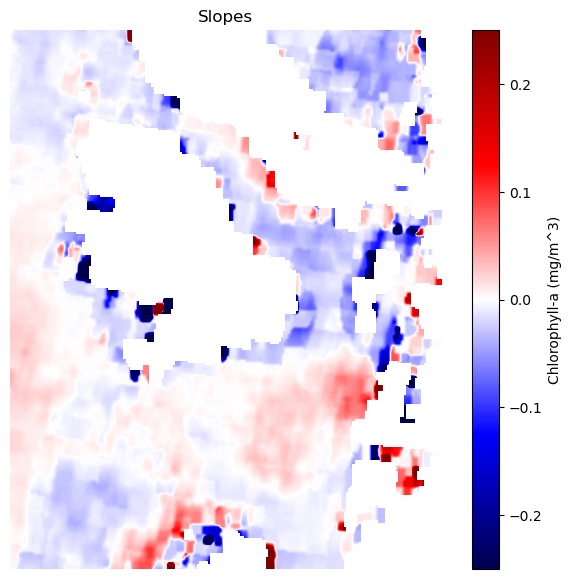

In [166]:
# # Get the years from the datetime column (for title)
# years = ds.datetime.dt.year.values
# years = np.unique(years)
# years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_data, origin='lower', cmap='seismic', vmin=-.25, vmax=.25, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('Slopes')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

In [185]:
transposed_directory = '/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/chunked_files2/transposed2'
files = glob.glob(os.path.join(transposed_directory, '*rmse.nc'))
files.sort()
files
# load in all the files
# ds_trend = xr.open_mfdataset(files[:], combine='by_coords')


ds_rmse = xr.open_mfdataset(files[:], combine='by_coords')
ds_rmse

<xarray.Dataset>
Dimensions:  (x: 200, y: 250)
Coordinates:
  * x        (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y        (y) int64 -2333975 -2332975 -2331975 ... -2086975 -2085975 -2084975
Data variables:
    rsme     (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [186]:
# rename the column rsme to rmse
ds_rmse = ds_rmse.rename({'rsme': 'rmse'})
ds_rmse

<xarray.Dataset>
Dimensions:  (x: 200, y: 250)
Coordinates:
  * x        (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y        (y) int64 -2333975 -2332975 -2331975 ... -2086975 -2085975 -2084975
Data variables:
    rmse     (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>

In [187]:
# write ds_rmse to ../datafiles/rmse.nc
ds_rmse.to_netcdf('/Users/tara/Documents/SJSU/MLML/CHANGED/changed/data_files/rmse.nc')


In [156]:
rmse_data = ds_rmse['rmse'].values

rmse_data = np.fliplr(rmse_data)
# # chla_data = np.fliplr(ds_mean.chla.values)
rotated_data = np.rot90(rmse_data, 1)


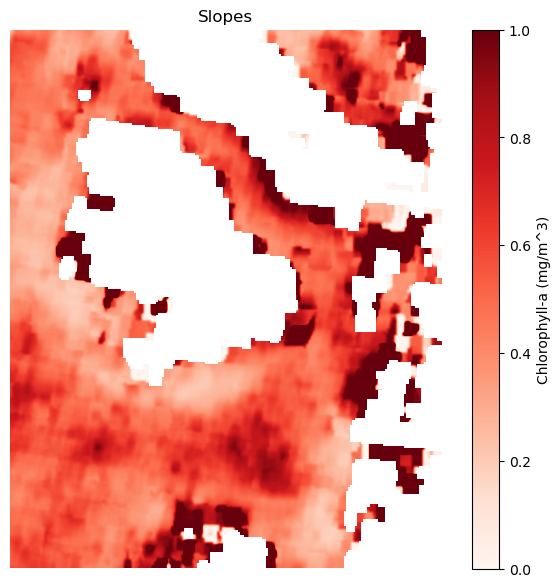

In [159]:
# # Get the years from the datetime column (for title)
# years = ds.datetime.dt.year.values
# years = np.unique(years)
# years.sort()

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rotated_data, origin='lower', cmap='Reds', vmin=0, vmax=1, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('Slopes')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')

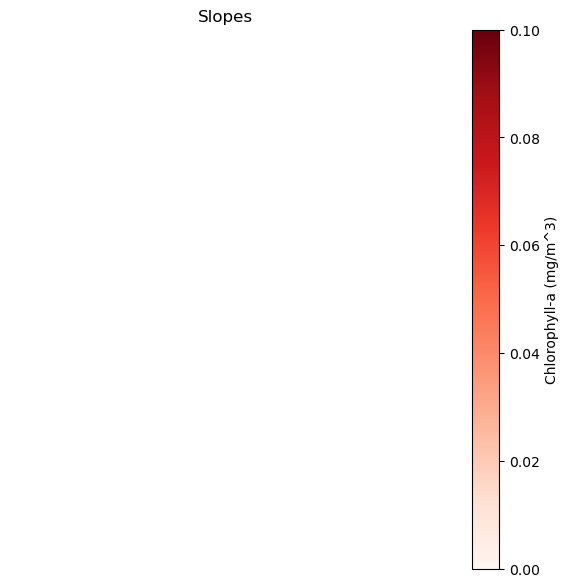

In [170]:
# normalize all rmse values to be between 0 and 1
rmse_data = ds_rmse['rmse'].values

rmse_data = (rmse_data - rmse_data.min()) / (rmse_data.max() - rmse_data.min())
# add rmse to ds_rmse
ds_rmse['rmse_norm'] = xr.DataArray(rmse_data, coords=ds_rmse.rmse.coords, dims=ds_rmse.rmse.dims)

rmse_data = ds_rmse['rmse_norm'].values
rmse_data = np.fliplr(rmse_data)
rmse_data = np.rot90(rmse_data, 1)

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rmse_data, origin='lower', cmap='Reds', vmin=0, vmax=1, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('Slopes')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')


In [172]:
ds_rmse

<xarray.Dataset>
Dimensions:    (x: 200, y: 250)
Coordinates:
  * x          (x) int64 -402475 -401475 -400475 ... -205475 -204475 -203475
  * y          (y) int64 -2333975 -2332975 -2331975 ... -2085975 -2084975
Data variables:
    rmse       (x, y) float64 dask.array<chunksize=(50, 50), meta=np.ndarray>
    rmse_norm  (x, y) float64 nan nan nan nan nan nan ... nan nan nan nan nan

In [180]:
rmse_data = ds_rmse['rmse']

# Calculate the minimum and maximum, ignoring NaN values
min_rmse = np.nanmin(rmse_data)
max_rmse = np.nanmax(rmse_data)

# Normalize the RMSE data
normalized_rmse = (rmse_data.data - min_rmse) / (max_rmse - min_rmse)

# Add the normalized RMSE data to the dataset as a new variable
ds_rmse['normalized_rmse'] = ('x', 'y'), normalized_rmse


In [184]:
np.nanmax(ds_rmse['rmse'].values)

18.503867890946676

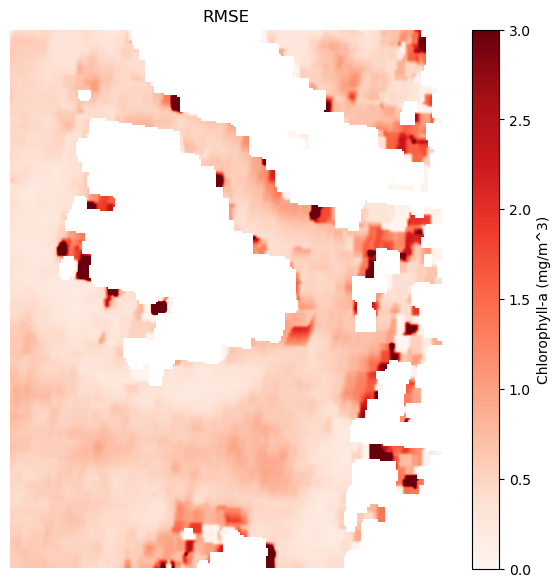

In [182]:
# normalize all rmse values to be between 0 and 1
rmse_data =ds_rmse['rmse'].values
rmse_data = np.fliplr(rmse_data)
rmse_data = np.rot90(rmse_data, 1)

# Create a new figure
plt.figure(figsize=(8, 7))

# Plot a heatmap of the mean chla with bicubic interpolation
plt.imshow(rmse_data, origin='lower', cmap='Reds', vmin=0, vmax=3, interpolation='bicubic')

# plt.title('Average Chlorophyll-a Concentration\n{:d} - {:d}'.format(years[0], years[-1]), fontsize=14)
plt.title('RMSE')

# Hide the axes and ticks
plt.axis('off')

# Add a colorbar
plt.colorbar(label='Chlorophyll-a (mg/m^3)')

# Show & close the plot
plt.show()
plt.close('all')


# All months but pre-2003